<a href="https://colab.research.google.com/github/dmswl0707/Transfer_learning_pytorch/blob/main/transfer_learning_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from __future__ import print_function, division


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
from torch.autograd import Variable 
import numpy as np
import torchvision
from torchvision import datasets, models, transforms 
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import matplotlib.pyplot as plt 

import time 
import os 
import copy


plt.ion() #interactive model


model_name="resnet"
num_classes = 2
batch_size=8
num_epochs=25
feature_extract=True


#데이터로드와 augmentation

디렉토리에서 hymenoptera_data를 로드합니다.


```
torch.utils.data.DataLoader
```


데이터셋을 로드한 다음, 학습을 위해(조금 더 나은 정확도를 위해) 데이터 증강과 일반화를 적용합니다.


```
transforms.Compose([...])
```



In [4]:
###학습을 위한 데이터 증가(augmentation)과 일반화하기
#Data augmentation - 학습용 데이터셋의 개수가 부족할 때, 각 영상을 Rotate/Flip/Crop/Shift/Partial masking/HIS distortion 등을 적용해 데이터셋을 확장시키는 방법 
data_transform={'train': transforms.Compose([
                    transforms.RandomResizedCrop(224),#transforms.RandomResizedCrop(size) - 이미지 사이즈를 size로 변경한다
                    transforms.RandomHorizontalFlip(), #랜덤으로수평으로뒤집음
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) #transforms.Normalize(mean, std, inplace=False) - 이미지를 정규화한다.
                    ]),
                'val':transforms.Compose([
                   transforms.Resize(256),
                   transforms.CenterCrop(224),
                   transforms.ToTensor(),
                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
#########데이터로드##############

##데이터 불러오기-torchvision, torch.utils.data

from google.colab import drive
drive.mount('/content/drive')
data_dir='/content/drive/My Drive/Colab Notebooks/data/hymenoptera_data'

###데이터로드

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#이미지 시각화
불러온 이미지를 시각화하는 단계입니다.
numpy를 이용해서 iteration을 반복하여 클래스에 대한 그리드를 불러옵니다.
이 부분은 데이터셋마다 달라집니다!

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


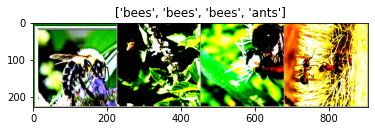

In [6]:
###이미지 예제 시각화

def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1,2,0)) #행렬 거꾸로 만들기
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225]) 
    inp = std+inp+mean
    inp = np.clip(inp, 0, 1) #clip 함수 : 최소값과 최대값 조건으로 값을 기준으로 해서, 이 범위 기준을 벗어나는 값에 대해서는 일괄적으로 최소값, 최대값으로 대치
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) #업데이트하기 위해 잠시 멈충

inputs, classes = next(iter(dataloaders['train']))

out=torchvision.utils.make_grid(inputs) #배치 가져오기

imshow(out,title=[class_names[x] for x in classes]) #그리드 만들기

# 모델 학습 


```
for epoch in range(num_epochs):
```
에폭 안으로 train loader와 validation loader를 나누어 불러옵니다.
train phase에서는 model.train()을, 
val phase에서는 model.eval()을 설정해 줍니다.
val pahse에서는 역전파를 진행하지 않습니다.


```
running_loss += loss.item() * inputs.size(0)
running_corrects += torch.sum(preds == labels.data)

epoch_loss = running_loss / dataset_sizes[phase]
epoch_acc = running_corrects.double() / dataset_sizes[phase]


```
학습은 진행사항을 보기 위해, 에폭마다 loss와 acc를 프린트합니다.



In [7]:
####모델 학습하기

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [8]:
###모델 예측값 시각화하기 

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)
    

#사전학습된 모델 불러오기
이 코드에선 모델에 대한 정의가 따로 없습니다.
대신 사전학습된 모델을 불러와서, FC층만 바꿔줍니다.


```
#pretrained=True 일 때, 사전학습된 모델을 불러올 수 있습니다.
model_ft = models.resnet18(pretrained=True)
```
num_ftts로 피쳐, 즉 샘플 크기를 변수로 선언하고,
nn.Linear()를 통해, 출력 샘플 크기를 클래스 갯수로 일반화 해줍니다.


```
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

```





In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7055 Acc: 0.6311
val Loss: 0.2285 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.5513 Acc: 0.7746
val Loss: 0.3542 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.4555 Acc: 0.8115
val Loss: 0.4937 Acc: 0.7778

Epoch 3/24
----------
train Loss: 0.6164 Acc: 0.7459
val Loss: 0.3162 Acc: 0.8627

Epoch 4/24
----------
train Loss: 0.5569 Acc: 0.7705
val Loss: 0.2455 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4168 Acc: 0.8279
val Loss: 0.2123 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.3250 Acc: 0.8648
val Loss: 0.2125 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3474 Acc: 0.8852
val Loss: 0.1840 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2785 Acc: 0.8934
val Loss: 0.2071 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2041 Acc: 0.9098
val Loss: 0.2555 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.3606 Acc: 0.8402
val Loss: 0.1884 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3231 Acc: 0.8443
val Loss: 0.2169 Acc: 0.9216

Epoch 12/24
----------
t

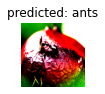

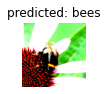

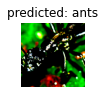

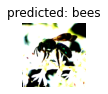

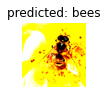

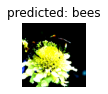

In [ ]:
visualize_model(model_ft)

고정된 특징 추출기로써의 합성곱 신경망?
#모델 테스트

저는 개인적으로, 이 부분이 처음엔 이해가 잘 안됐는데,
간단하게 테스트 단계라고 생각하시면 될 것 같습니다.

위와 같이 사전학습된 모델을 불러오되, 다만 require_grad를 False로 지정합니다.
역전파를 진행하지 않겠다는 의미입니다.


```
# 모델 변수가 다른 것에 유의해야합니다. 위의 모델을 사용하면 같은 작업을 반복하게 될 것입니다!
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
```



In [12]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6216 Acc: 0.6762
val Loss: 0.2927 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.4357 Acc: 0.7664
val Loss: 0.3468 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.7169 Acc: 0.7049
val Loss: 0.2278 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4652 Acc: 0.8115
val Loss: 0.1899 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4079 Acc: 0.8033
val Loss: 0.2398 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.3913 Acc: 0.8320
val Loss: 0.1631 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.5099 Acc: 0.7787
val Loss: 0.3101 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.3276 Acc: 0.8770
val Loss: 0.1696 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3512 Acc: 0.8525
val Loss: 0.1699 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.2947 Acc: 0.8852
val Loss: 0.1824 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3469 Acc: 0.8402
val Loss: 0.1687 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3563 Acc: 0.8566
val Loss: 0.1752 Acc: 0.9477

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


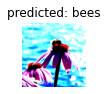

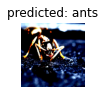

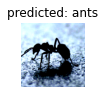

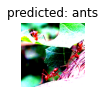

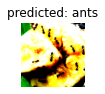

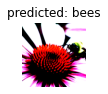

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()